Your Tasks
1. Download and convert data to a text-based music notation format
2. Design a tokenization scheme
• Options: character-level, note-level, or custom music-aware tokens
• Justify your choice in the report
• Document vocabulary size
3. Create train/validation/test splits
• Recommended: 98% / 1% / 1% or similar
• Ensure at least 100M tokens in training set for each model
4. Data cleaning
• Handle invalid/corrupted files
• Decide how to handle very short or very long sequences
• Document any filtering criteria

In [3]:
import os
from pathlib import Path
import json

# Get the project root (parent of current directory if notebook is in subfolder)
# Adjust this based on where your notebook is located
NOTEBOOK_DIR = Path().absolute()
if "data-collection-and-preprocessing" in str(NOTEBOOK_DIR):
    # Notebook is in subdirectory, go up one level
    PROJECT_ROOT = NOTEBOOK_DIR.parent
else:
    # Notebook is in project root
    PROJECT_ROOT = NOTEBOOK_DIR

# Set paths relative to project root
DATA_DIR = PROJECT_ROOT / "data"
LMD_DIR = DATA_DIR / "lmd_matched"
MATCH_SCORES = DATA_DIR / "match_scores.json"

# Verify paths exist
print(f"Project root: {PROJECT_ROOT}")
print(f"Data directory exists: {DATA_DIR.exists()}")
print(f"LMD directory exists: {LMD_DIR.exists()}")
print(f"Match scores exists: {MATCH_SCORES.exists()}")

if not LMD_DIR.exists():
    print(f"\nERROR: {LMD_DIR} not found!")
    print(f"Current working directory: {os.getcwd()}")
    print(f"Please check the path or run the data_collection.py script first.")
else:
    # Count MIDI files
    midi_files = list(LMD_DIR.rglob("*.mid"))
    print(f"\nTotal MIDI files: {len(midi_files):,}")
    
    # Show directory structure
    print("\nDirectory structure (first 5 levels):")
    dirs = sorted([d for d in LMD_DIR.iterdir() if d.is_dir()])[:5]
    for path in dirs:
        subdirs = list(path.iterdir())
        print(f"  {path.name}/ -> {len(subdirs)} subdirectories")
        if subdirs:
            print(f"    Example: {subdirs[0].name}/")
    
    # Show example MIDI file paths
    print("\nExample MIDI file paths:")
    for midi_file in midi_files[:5]:
        print(f"  {midi_file.relative_to(PROJECT_ROOT)}")

Project root: /Users/sd6201/Documents/Workspace/symbolic-music-llm-scaling-laws
Data directory exists: True
LMD directory exists: True
Match scores exists: True

Total MIDI files: 116,189

Directory structure (first 5 levels):
  A/ -> 26 subdirectories
    Example: R/
  B/ -> 26 subdirectories
    Example: R/
  C/ -> 26 subdirectories
    Example: R/
  D/ -> 26 subdirectories
    Example: R/
  E/ -> 26 subdirectories
    Example: R/

Example MIDI file paths:
  data/lmd_matched/R/R/U/TRRRUTV12903CEA11B/2740bc2a1cd9bae5dfb5ddc40f2aefb9.mid
  data/lmd_matched/R/R/U/TRRRUTV12903CEA11B/69df087321438541ae7c8f064b109917.mid
  data/lmd_matched/R/R/U/TRRRUTV12903CEA11B/8fb2f7f63945b607141c6b6d342e41a5.mid
  data/lmd_matched/R/R/U/TRRRUTV12903CEA11B/a8a167f3ab4d81560b65095e7565a837.mid
  data/lmd_matched/R/R/U/TRRRUTV12903CEA11B/aeb62a3ea1b8608e6c5cf4a83249dbae.mid


In [4]:
# Load match scores
with open(MATCH_SCORES, 'r') as f:
    scores = json.load(f)

print(f"Total songs matched: {len(scores)}")
print(f"\nExample entry:")
# Get first song ID
first_song_id = list(scores.keys())[0]
print(f"Song ID: {first_song_id}")
print(f"Number of MIDI matches: {len(scores[first_song_id])}")
print(f"Match scores: {list(scores[first_song_id].values())[:3]}")

Total songs matched: 31034

Example entry:
Song ID: TRRNARX128F4264AEB
Number of MIDI matches: 1
Match scores: [0.7040202098544246]


In [6]:
import pretty_midi
import music21

# Get a MIDI file
example_midi = midi_files[0]
print(f"Loading: {example_midi}")

# Method 1: Using pretty_midi
pm = pretty_midi.PrettyMIDI(str(example_midi))
print(f"\nPrettyMIDI Info:")
print(f"  Duration: {pm.get_end_time():.2f} seconds")
print(f"  Number of instruments: {len(pm.instruments)}")
print(f"  Total notes: {sum(len(inst.notes) for inst in pm.instruments)}")

# Show instruments
for i, inst in enumerate(pm.instruments[:5]):
    print(f"  Instrument {i}: {pretty_midi.program_to_instrument_name(inst.program)} "
          f"({len(inst.notes)} notes)")

# Method 2: Using music21 (with error handling)
score = music21.converter.parse(str(example_midi))
print(f"\nMusic21 Info:")
print(f"  Parts: {len(score.parts)}")

# Try to get key - filter out unpitched notes first
try:
    # Create a copy with only pitched notes for key analysis
    pitched_score = score.chordify()
    # Remove unpitched elements
    for element in pitched_score.recurse():
        if hasattr(element, 'pitch') and element.pitch is None:
            pitched_score.remove(element)
    
    key = pitched_score.analyze('key')
    print(f"  Key: {key}")
except Exception as e:
    print(f"  Key: Could not analyze (may contain unpitched percussion): {e}")
    # Alternative: try analyzing individual parts
    try:
        for i, part in enumerate(score.parts[:3]):
            try:
                part_key = part.analyze('key')
                print(f"    Part {i} key: {part_key}")
            except:
                pass
    except:
        pass

# Time signature (usually works fine)
try:
    ts = score.timeSignature
    print(f"  Time signature: {ts}")
except:
    print(f"  Time signature: Not found")

Loading: /Users/sd6201/Documents/Workspace/symbolic-music-llm-scaling-laws/data/lmd_matched/R/R/U/TRRRUTV12903CEA11B/2740bc2a1cd9bae5dfb5ddc40f2aefb9.mid

PrettyMIDI Info:
  Duration: 140.80 seconds
  Number of instruments: 7
  Total notes: 4013
  Instrument 0: Acoustic Grand Piano (337 notes)
  Instrument 1: Acoustic Grand Piano (1067 notes)
  Instrument 2: Acoustic Grand Piano (207 notes)
  Instrument 3: Acoustic Grand Piano (214 notes)
  Instrument 4: Acoustic Grand Piano (196 notes)

Music21 Info:
  Parts: 7
  Key: Could not analyze (may contain unpitched percussion): 'PercussionChord' object has no attribute 'pitch'
    Part 0 key: E- major
    Part 1 key: B- major
    Part 2 key: g minor
  Time signature: None


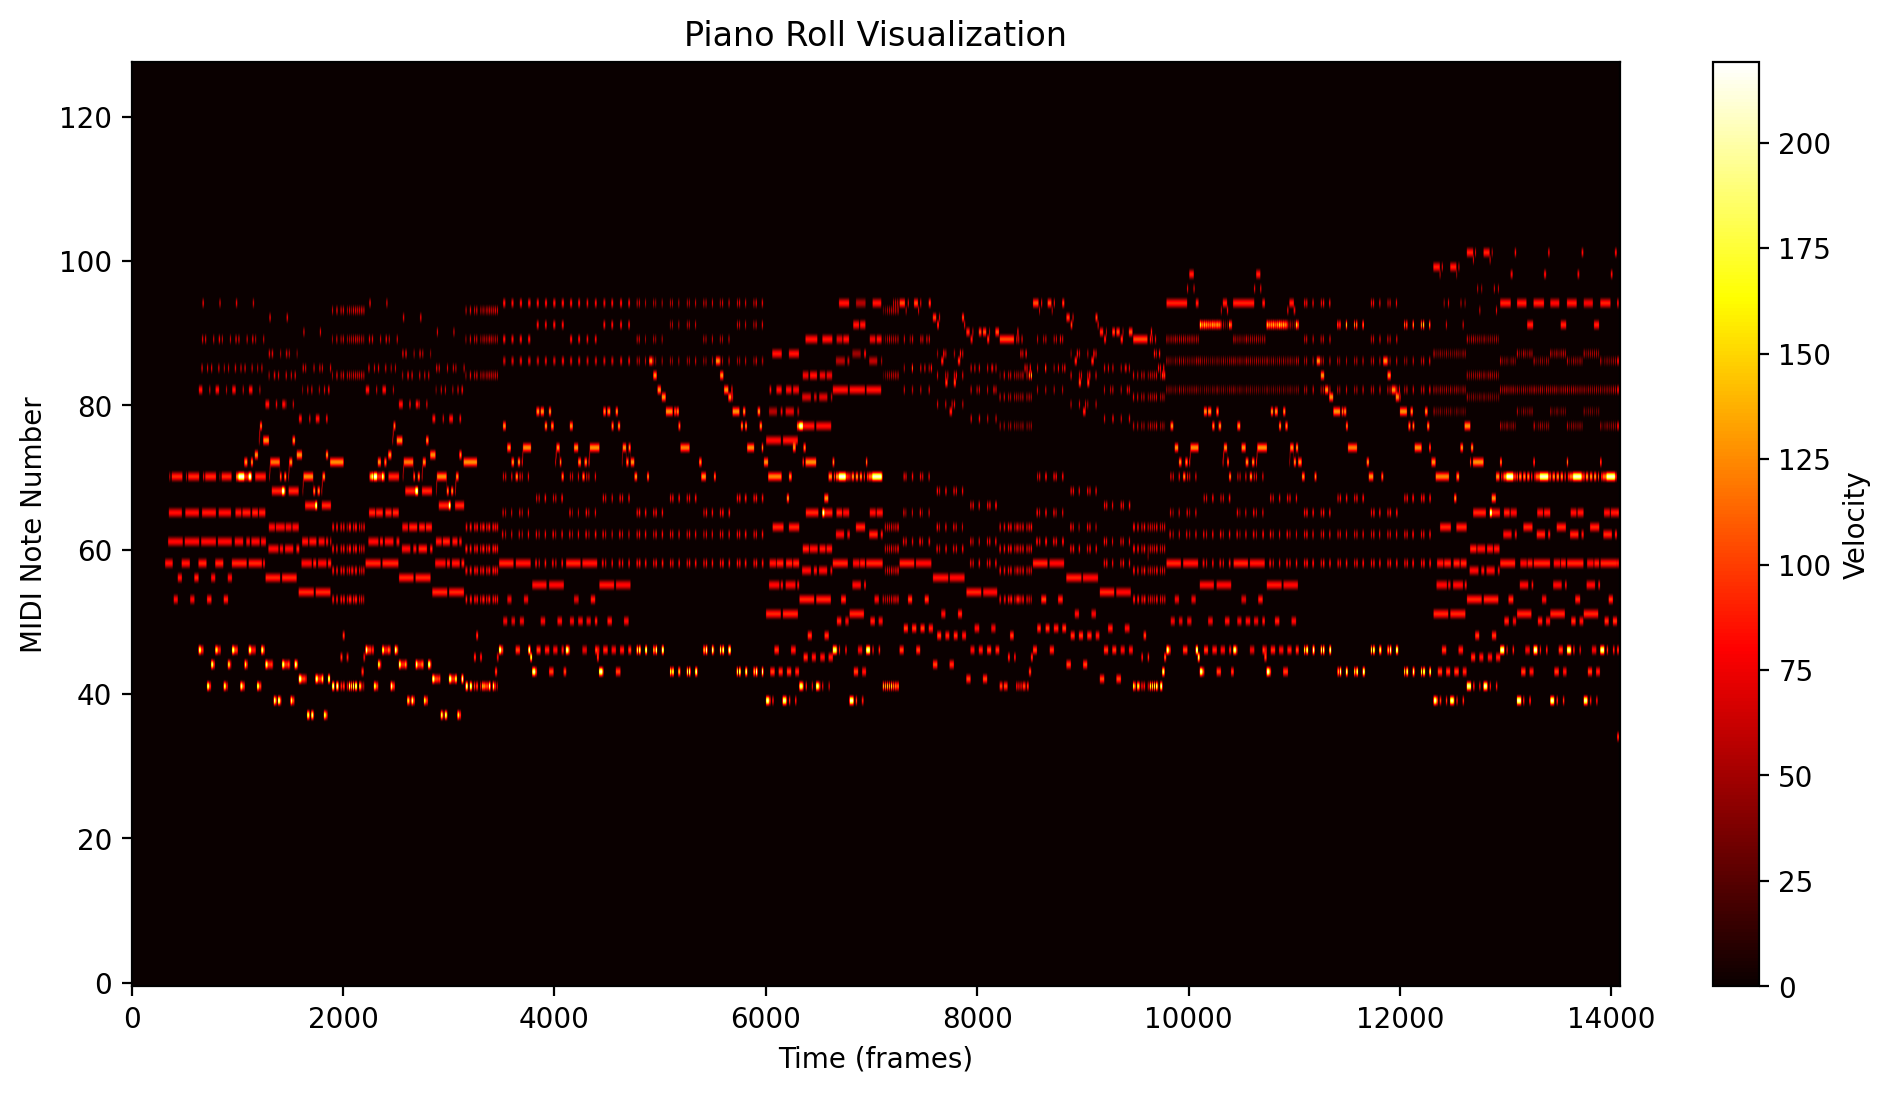

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Load a MIDI file
pm = pretty_midi.PrettyMIDI(str(midi_files[0]))

# Get piano roll
piano_roll = pm.get_piano_roll(fs=100)  # 100 Hz resolution

# Plot
plt.figure(figsize=(12, 6))
plt.imshow(piano_roll, aspect='auto', origin='lower', cmap='hot')
plt.xlabel('Time (frames)')
plt.ylabel('MIDI Note Number')
plt.title('Piano Roll Visualization')
plt.colorbar(label='Velocity')
plt.show()

In [9]:
# Cell: Setup and get MIDI files
import os
from pathlib import Path

NOTEBOOK_DIR = Path().absolute()
if "data-collection-and-preprocessing" in str(NOTEBOOK_DIR):
    PROJECT_ROOT = NOTEBOOK_DIR.parent
else:
    PROJECT_ROOT = NOTEBOOK_DIR

DATA_DIR = PROJECT_ROOT / "data"
LMD_DIR = DATA_DIR / "lmd_matched"
MATCH_SCORES = DATA_DIR / "match_scores.json"

# Always create midi_files list
if LMD_DIR.exists():
    midi_files = list(LMD_DIR.rglob("*.mid"))
    print(f"Found {len(midi_files):,} MIDI files")
else:
    midi_files = []
    print(f"ERROR: {LMD_DIR} not found!")

Found 116,189 MIDI files


In [10]:
%cat /Users/sd6201/Documents/Workspace/symbolic-music-llm-scaling-laws/data/lmd_matched/A/A/A/TRAAAGR128F425B14B/1d9d16a9da90c090809c153754823c2b.mid


MThd      �MTrk    �X �Q�  �/ MTrk  ' �! �main synth           �>�Ed@�Ed�LdF�Ld�JdF�Jd�Hd5�Hd �EdB�Ed�LdH�Ld�JdE�Jd�Hd2�Hd �Jd'�Jd �Hd6�Hd �AdB�Ad�HdF�Hd�GdG�Gd�Ed3�Ed �Cd?�Cd%�Jd<�Jd*�HdJ�Hd�Gd4�Gd�Hd#�Hd�Gd5�Gd�Ed@�Ed�LdF�Ld�JdF�Jd�Hd5�Hd �EdB�Ed�LdH�Ld�JdE�Jd�Hd2�Hd �Jd'�Jd �Hd6�Hd �AdB�Ad�HdF�Hd�GdG�Gd�Ed3�Ed �Cd?�Cd%�Jd<�Jd*�HdJ�Hd�Gd4�Gd�Hd#�Hd�Gd5�Gd�Ed@�Ed�LdF�Ld�JdF�Jd�Hd5�Hd �EdB�Ed�LdH�Ld�JdE�Jd�Hd2�Hd �Jd'�Jd �Hd6�Hd �AdB�Ad�HdF�Hd�GdG�Gd�Ed3�Ed �Cd?�Cd%�Jd<�Jd*�HdJ�Hd�Gd4�Gd�Hd#�Hd�Gd5�Gd�Ed@�Ed�LdF�Ld�JdF�Jd�Hd5�Hd �EdB�Ed�LdH�Ld�JdE�Jd�Hd2�Hd �Jd'�Jd �Hd6�Hd �AdB�Ad�HdF�Hd�GdG�Gd�Ed3�Ed �Cd?�Cd%�Jd<�Jd*�HdJ�Hd�Gd4�Gd�Hd#�Hd�Gd5�Gd�Ed@�Ed�LdF�Ld�JdF�Jd�Hd5�Hd �EdB�Ed�LdH�Ld�JdE�Jd�Hd2�Hd �Jd'�Jd �Hd6�Hd �AdB�Ad�HdF�Hd�GdG�Gd�Ed3�Ed �Cd?�Cd%�Jd<�Jd*�HdJ�Hd�Gd4�Gd�Hd#�Hd�Gd5�Gd�Ed@�Ed�LdF�Ld�JdF�Jd�Hd5�Hd �EdB�Ed�LdH�Ld�JdE�Jd�Hd2�Hd �Jd'�Jd �Hd6�Hd �AdB�Ad�HdF�Hd�GdG�Gd�Ed3�Ed �Cd?�Cd%